The following simulated classification dataset consists of N = 300 samples, each assigned to one of three class labels.

In [1]:
import torch
from torch import nn, optim, utils
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
!gdown 1_n5odu1KSpBAqO_Ddbqy2Ty0mG12Dr0A
!gdown 1C7GK_uY0srlUdLfHfGa4IZcfthmmdROr

Downloading...
From: https://drive.google.com/uc?id=1_n5odu1KSpBAqO_Ddbqy2Ty0mG12Dr0A
To: c:\Users\Vincent\Proton Drive\vincent.kehl\My files\Projekte\spiral_features.npy

  0%|          | 0.00/4.93k [00:00<?, ?B/s]
100%|██████████| 4.93k/4.93k [00:00<00:00, 354kB/s]
Downloading...
From: https://drive.google.com/uc?id=1C7GK_uY0srlUdLfHfGa4IZcfthmmdROr
To: c:\Users\Vincent\Proton Drive\vincent.kehl\My files\Projekte\spiral_target.npy

  0%|          | 0.00/428 [00:00<?, ?B/s]
100%|██████████| 428/428 [00:00<00:00, 37.3kB/s]


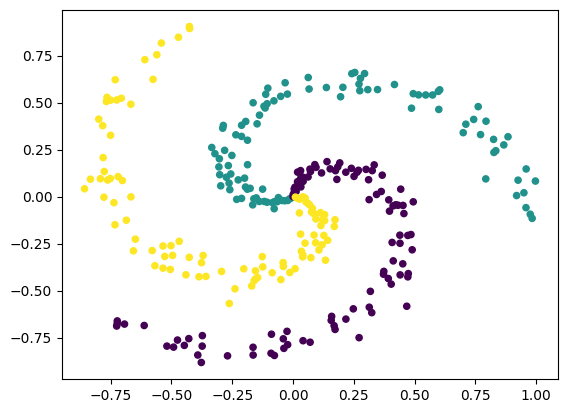

In [3]:
features = (np.load("spiral_features.npy")
              .astype(np.float32))
target = np.load("spiral_target.npy")

# visualize the data
plt.scatter(features[:, 0], features[:, 1], c=target, s=20)
plt.show()

One-hot encoding converts categorical labels into binary vectors, making them suitable for machine learning models. Each label is represented as a vector where only one position is set to 1, preventing the model from interpreting categorical values as ordinal. This is essential for algorithms that require numerical inputs.

In [4]:
def split_data(features, target, train_ratio):
    # Determine the number of samples for training
    num_train_samples = int(train_ratio * features.shape[0])

    # Create an array of indices for shuffling
    index = np.arange(features.shape[0])
    np.random.shuffle(index)

    # Split indices into training and testing indeces
    train_index = index[:num_train_samples]
    test_index = index[num_train_samples:]

    # Split features and target using indices and convert to numPy-Array
    features_train = features[train_index]
    features_test = features[test_index]
    target_train = target[train_index]
    target_test = target[test_index]

    return features_train, features_test, target_train, target_test

In [5]:
# Define a function to perform one-hot encoding (turn categorial data into binary vector)
def one_hot_encode(labels, num_classes):
    num_samples = len(labels) # number of labels
    one_hot_labels = np.zeros((num_samples, num_classes)) # init matrix

    for i in range(num_samples):
        label = labels[i] # Get the current label value
        one_hot_labels[i, label] = 1 # set position to 1

    return one_hot_labels

Split the dataset into training and testing sets. Keep 80% of the data for training and 20% of the data for testing.

In [6]:
# Define train-ratio and split the data using the function split_data
train_ratio = 0.8
features_train, features_test, target_train, target_test = split_data(features, target, train_ratio)

# Apply one-hot encoding to the target values
num_classes = 3
target_train_encoded = one_hot_encode(target_train, num_classes)
target_test_encoded = one_hot_encode(target_test, num_classes)

print(features_train.shape)
print(features_test.shape)
print(target_train_encoded[:7])

(240, 2)
(60, 2)
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


Using the provided datasets and dataloaders, implement a 3-class logistic regression classifier in PyTorch and train it using gradient descent.

In [7]:
# create tensors
train_features_tensor = torch.from_numpy(features_train)
train_target_tensor = torch.from_numpy(target_train_encoded)
test_features_tensor = torch.from_numpy(features_test)
test_target_tensor = torch.from_numpy(target_test_encoded)

# create datasets from tensors
train_dataset = utils.data.TensorDataset(train_features_tensor, train_target_tensor)
test_dataset = utils.data.TensorDataset(test_features_tensor, test_target_tensor)

# Create data loaders from datasets
train_dataloader = utils.data.DataLoader(train_dataset, batch_size=40, shuffle=True)
test_dataloader = utils.data.DataLoader(test_dataset, batch_size=40, shuffle=False)

## from scratch implementation

Iteration 250/2000 -> Train Loss: 0.0794 - Train Accuracy: 0.8917 - Test Loss: 0.0776 - Test Accuracy: 0.9000
Iteration 500/2000 -> Train Loss: 0.0647 - Train Accuracy: 0.9208 - Test Loss: 0.0619 - Test Accuracy: 0.9500
Iteration 750/2000 -> Train Loss: 0.0571 - Train Accuracy: 0.9583 - Test Loss: 0.0545 - Test Accuracy: 0.9667
Iteration 1000/2000 -> Train Loss: 0.0520 - Train Accuracy: 0.9625 - Test Loss: 0.0501 - Test Accuracy: 0.9667
Iteration 1250/2000 -> Train Loss: 0.0483 - Train Accuracy: 0.9667 - Test Loss: 0.0472 - Test Accuracy: 0.9667
Iteration 1500/2000 -> Train Loss: 0.0455 - Train Accuracy: 0.9625 - Test Loss: 0.0452 - Test Accuracy: 0.9667
Iteration 1750/2000 -> Train Loss: 0.0431 - Train Accuracy: 0.9625 - Test Loss: 0.0437 - Test Accuracy: 0.9667
Iteration 2000/2000 -> Train Loss: 0.0412 - Train Accuracy: 0.9625 - Test Loss: 0.0426 - Test Accuracy: 0.9667
Training finished.


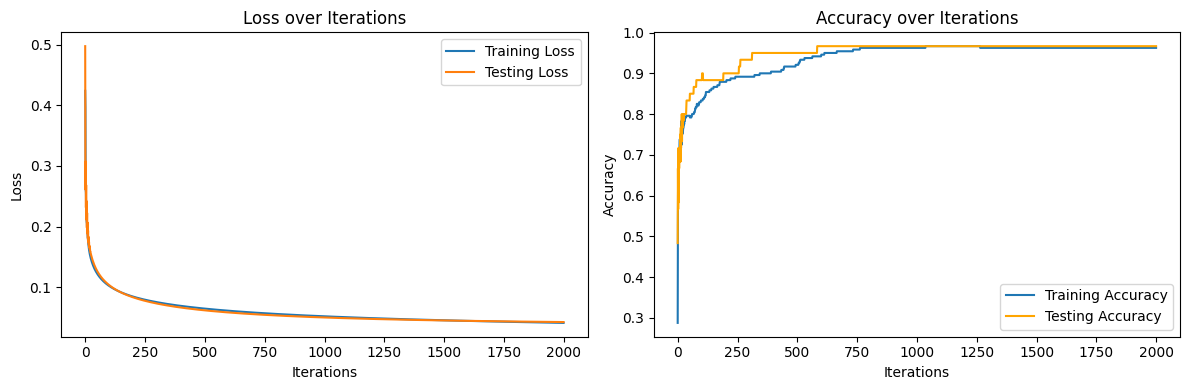

In [8]:
# Define functions for logistic regression
def get_z(A, weights):
    return A @ weights

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def get_loss(target_encoded, target_pred):
    return np.mean(-np.mean(target_encoded * np.log(target_pred), axis=0))

def transform_features(features, num_basis_functions):
    transformed_features = []
    for i in range(num_basis_functions):
        for j in range(num_basis_functions):
            transformed_features.append(features[:, 0]**i * features[:, 1]**j)
    return np.array(transformed_features).T

def calculate_accuracy(predictions, targets):
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_classes == targets)
    return accuracy

# Create higher dimensional features
num_basis_functions = 9
A_train = transform_features(features_train, num_basis_functions)
A_test = transform_features(features_test, num_basis_functions)

# Determine the number of classes
num_classes = target_train_encoded.shape[1]

# Initialize weights matrix with random values
weights = np.random.randn(A_train.shape[1], num_classes)

# Set hyperparameters
learning_rate = 0.034
num_iterations = 2000

# Lists to store training progress
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for i in range(num_iterations):

    # Forward pass for training data
    z_train = get_z(A_train, weights)
    target_pred_train = softmax(z_train)
    loss_train = get_loss(target_train_encoded, target_pred_train)
    train_losses.append(loss_train)

    # Backward pass for training data
    gradient_train = A_train.T @ (target_pred_train - target_train_encoded)
    weights = weights - learning_rate * gradient_train

    # Calculate accuracy for training data
    target_pred_class_train = np.argmax(target_pred_train, axis=1)
    accuracy_train = np.mean(target_pred_class_train == target_train)
    train_accuracies.append(accuracy_train)

    # Forward pass for testing data
    z_test = get_z(A_test, weights)
    target_pred_test = softmax(z_test)
    loss_test = get_loss(target_test_encoded, target_pred_test)
    test_losses.append(loss_test)

    # Calculate accuracy for testing data
    target_pred_class_test = np.argmax(target_pred_test, axis=1)
    accuracy_test = np.mean(target_pred_class_test == target_test)
    test_accuracies.append(accuracy_test)

    # Print error and accuracy for training data
    if (i + 1) % 250 == 0:
        print(f"Iteration {i+1}/{2000} -> Train Loss: {loss_train:.4f} - Train Accuracy: {accuracy_train:.4f} - Test Loss: {loss_test:.4f} - Test Accuracy: {accuracy_test:.4f}")

print("Training finished.")

# Plot the loss and accuracy curves side by side
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.title("Loss over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Testing Accuracy", color="orange")
plt.title("Accuracy over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Assess the performance of the model on the training data and the testing data in terms of both loss and accuracy.

Training Loss: 0.0412
Training Accuracy: 0.9625
Test Loss: 0.0426
Test Accuracy: 0.9667


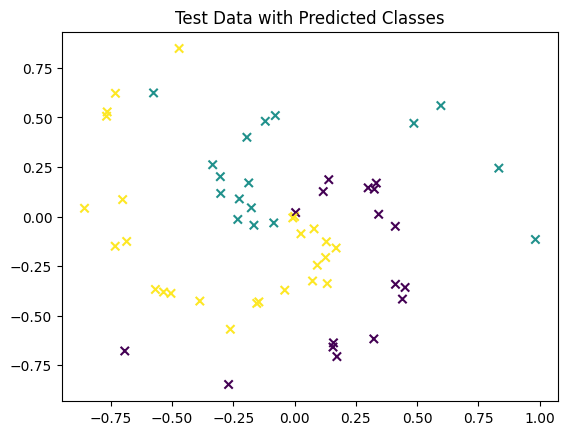

In [9]:
# Transform Training Features into higher order
A_train = transform_features(features_train, num_basis_functions)

# Forward Pass and Predictions for Training Data
z_train = get_z(A_train, weights)
target_pred_train = softmax(z_train)

# Calculate Loss and Accuracy for Training Data
loss_train = get_loss(target_train_encoded, target_pred_train)
accuracy_train = calculate_accuracy(target_pred_train, target_train)

# Print Training Results
print(f"Training Loss: {loss_train:.4f}")
print(f"Training Accuracy: {accuracy_train:.4f}")

# Transform Test Features intp higher order
A_test = transform_features(features_test, num_basis_functions)

# Forward Pass and Predictions for Test Data
z_test = get_z(A_test, weights)
target_pred_test = softmax(z_test)

# Calculate Loss and Accuracy for Test Data
loss_test = get_loss(target_test_encoded, target_pred_test)
accuracy_test = calculate_accuracy(target_pred_test, target_test)
target_pred_class_test = np.argmax(target_pred_test, axis=1)

# Print Test Results
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

# Visualize the test data with predicted classes using 'x' markers
plt.scatter(features_test[:, 0], features_test[:, 1], c=target_pred_class_test, marker="x")
plt.title("Test Data with Predicted Classes")
plt.show()

## PyTorch-based implementation

Iteration [250/2000] -> Loss: 0.7573
Iteration [500/2000] -> Loss: 0.7375
Iteration [750/2000] -> Loss: 0.7347
Iteration [1000/2000] -> Loss: 0.7332
Iteration [1250/2000] -> Loss: 0.7327
Iteration [1500/2000] -> Loss: 0.7324
Iteration [1750/2000] -> Loss: 0.7322
Iteration [2000/2000] -> Loss: 0.7321


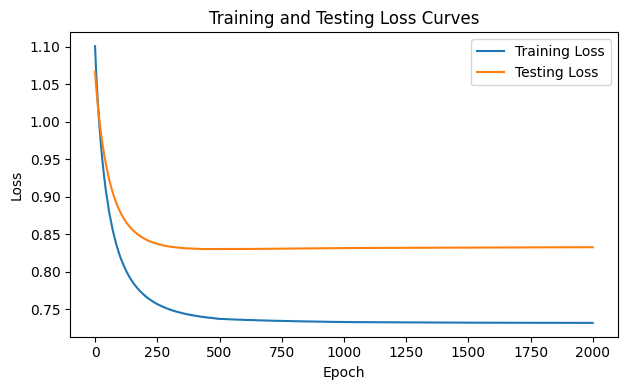

In [10]:
# Define a logistic regression model suitable for multi-class classification
input_size = features.shape[1]  # Number of features
num_classes = 3  # Number of classes
num_epochs = 2000  # Training epochs
learning_rate = 0.034  # Learning rate

# Define the model, optimizer, and loss function
model = nn.Linear(input_size, num_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)
lossfn = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

train_losses = []  # List to store training losses
test_losses = []   # List to store test losses

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    epoch_loss = 0
    for features_batch, target_batch in train_dataloader:
        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        outputs = model(features_batch)
        loss = lossfn(outputs, target_batch)  # Calculate loss

        # Backpropagation
        loss.backward() # calc gradients
        optimizer.step() # adjust parameters

        epoch_loss += loss.item()

    # Calculate average loss for this epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_epoch_loss)

    if (epoch + 1) % 250 == 0:
        print(f"Iteration [{epoch+1}/{num_epochs}] -> Loss: {avg_epoch_loss:.4f}")

    # Calculate test loss
    model.eval() # set model to evaluation mode
    with torch.no_grad(): # disable gradient calculation
        test_loss = 0
        for features_batch, target_batch in test_dataloader:
            # forward pass
            outputs = model(features_batch)

            # test los
            test_loss += lossfn(outputs, target_batch).item()

        # Calculate average test loss
        avg_test_loss = test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)

    # Step the learning rate scheduler
    scheduler.step()

# Plot the loss curves
plt.figure(figsize=(12, 4))

# Plot the loss curves for training and testing data on the same plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Curves")
plt.legend()
plt.tight_layout()
plt.show()

# Performance issues, high loss -> better use manual approach with high order features

## neural network classifier implementation



Epoch 250/2000 - Loss: 0.2003
Epoch 500/2000 - Loss: 0.0844
Epoch 750/2000 - Loss: 0.0601
Epoch 1000/2000 - Loss: 0.0440
Epoch 1250/2000 - Loss: 0.0378
Epoch 1500/2000 - Loss: 0.0324
Epoch 1750/2000 - Loss: 0.0300
Epoch 2000/2000 - Loss: 0.0278


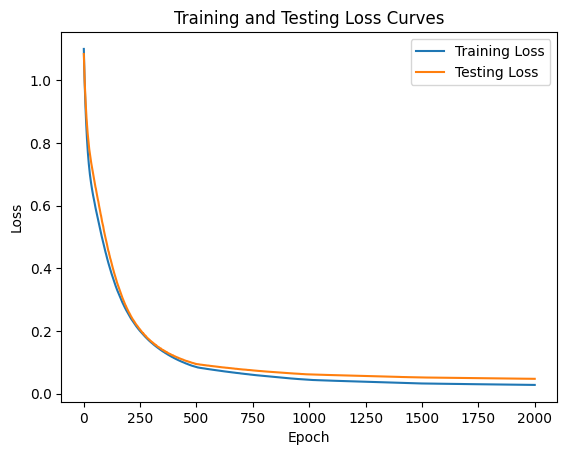

In [11]:
# Define the Classifier class
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Classifier, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

# Define a function for performance assessment
def assess_performance_q2(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for features, targets in dataloader:
            # move to gpu
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(features)

            # Compute the loss based on predicted and true labels
            loss = criterion(outputs, targets.argmax(dim=1))
            total_loss += loss.item()

            # Calculate the number of correct predictions
            total_correct += (outputs.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

            # Count the total number of samples in the dataset
            total_samples += targets.size(0)

    # Calculate the average loss and accuracy
    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    return average_loss, accuracy

# Define the training function
def train_classifier(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for features, targets in train_dataloader:
            # move to gpu
            features = features.to(device)
            targets = targets.to(device)

            # clear gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(features)

            # compute the loss
            loss = criterion(outputs, targets)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Add the current loss to the total loss
            total_loss += loss.item()

        # average loss
        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)

        if (epoch + 1) % 250 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

        # step scheduler
        scheduler.step()

        # Evaluate model performance on the test dataset
        test_loss = assess_performance_q2(model, test_dataloader, criterion, device)
        test_losses.append(test_loss)

    return train_losses, test_losses


# Set up the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the classifier
hidden_size = 100
num_classes = 3
model = Classifier(input_size=train_features_tensor.shape[1], hidden_size=hidden_size, num_classes=num_classes)
model.to(device)

# Hyperparameters
num_epochs = 2000
learning_rate = 0.001

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

# Train the model (same as before)
train_losses, test_losses = train_classifier(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, num_epochs, device)

# Plot
test_losses = [test_loss[0] for test_loss in test_losses]
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Curves")
plt.legend()
plt.show()



Assess the performance the neural network on the training data and the testing data in terms of both loss and accuracy.

In [ ]:
# Calculate performance metrics using the assess_performance function
train_loss, train_accuracy = assess_performance_q2(model, train_dataloader, criterion, device)
test_loss, test_accuracy = assess_performance_q2(model, test_dataloader, criterion, device)

# Print the calculated metrics
print(f"Loss (Training): {train_loss:.4f}")
print(f"Accuracy (Training): {train_accuracy:.4f}")

print(f"Loss (Testing): {test_loss:.4f}")
print(f"Accuracy (Testing): {test_accuracy:.4f}")

Loss (Training): 0.0278
Accuracy (Training): 0.9958
Loss (Testing): 0.0473
Accuracy (Testing): 0.9833



Compute the confusion matrix for the classifier on both the training and testing data 

In [13]:
from sklearn import metrics
import seaborn as sns

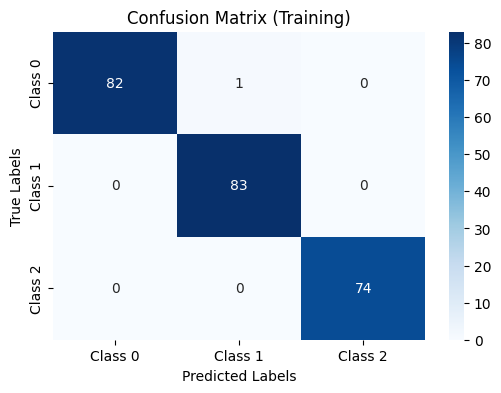

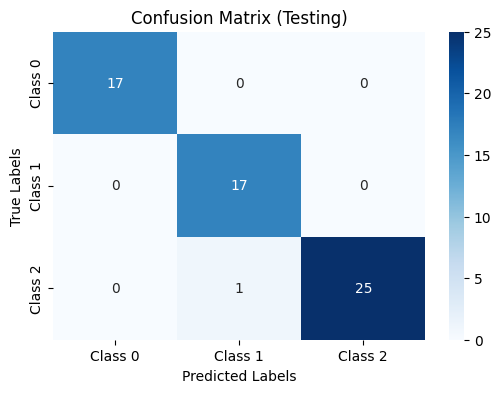

In [ ]:
# Define a function to get predictions and true labels
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for features, targets in dataloader:
            # move to gpu
            features = features.to(device)
            targets = targets.to(device)

            # forward pass
            outputs = model(features)

            # store predicted and actual labels
            predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
            true_labels.extend(torch.argmax(targets, dim=1).cpu().numpy())
            predictions.extend(predicted_labels)

    return np.array(predictions), np.array(true_labels)

# Get predictions and true labels for training data
train_predictions, train_true_labels = get_predictions_and_labels(model, train_dataloader, device)

# Get predictions and true labels for testing data
test_predictions, test_true_labels = get_predictions_and_labels(model, test_dataloader, device)

# Compute confusion matrices
train_confusion_matrix = metrics.confusion_matrix(train_true_labels, train_predictions)
test_confusion_matrix = metrics.confusion_matrix(test_true_labels, test_predictions)

# Define class labels
class_labels = ["Class 0", "Class 1", "Class 2"]

# Plot the confusion matrix for training data
plt.figure(figsize=(6, 4))
sns.heatmap(train_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (Training)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot the confusion matrix for testing data
plt.figure(figsize=(6, 4))
sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (Testing)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



Better deep neural network 

In [15]:
# Define the NN class
class NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NN, self).__init__()
        # create a list for hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])

        # Iterate over hidden_sizes to create additional hidden layers and append to the list
        for i in range(1, len(hidden_sizes)):
            # Create a linear layer connecting the previous hidden layer's output size to the current hidden layer's input size
            self.hidden_layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
        self.relu = nn.ReLU() # ReLU activation function
        self.output = nn.Linear(hidden_sizes[-1], num_classes) # output layer with specified number of classes

    def forward(self, x):
        # Iterate through each hidden layer
        for layer in self.hidden_layers:
            x = self.relu(layer(x)) # Apply ReLU activation
        x = self.output(x) # output layer
        return x

def train_NN(model, train_dataloader, num_iterations, criterion, optimizer, scheduler, device):
    train_losses = []

    for iteration in range(num_iterations):
        model.train()
        total_loss = 0

        for features, targets in train_dataloader:
            # move to gpu
            features = features.to(device)
            targets = targets.to(device)

            # clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backpropagation
            loss.backward()

            # Update the weights
            optimizer.step()

            # apply loss to totals
            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)

        if (iteration + 1) % 500 == 0:
            print(f"Iteration {iteration+1}/{num_iterations} - Loss: {avg_loss:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

    print("Training finished.")


# Set up the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the NN
hidden_sizes = [200, 150, 100]
num_classes = 3
model = NN(input_size=train_features_tensor.shape[1], hidden_sizes=hidden_sizes, num_classes=num_classes)
model.to(device)

# Hyperparameters
num_iterations = 3000
learning_rate = 0.0001

# Set Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

# Call the training loop function
train_NN(model, train_dataloader, num_iterations, criterion, optimizer, scheduler, device)


Iteration 500/3000 - Loss: 0.0311
Iteration 1000/3000 - Loss: 0.0143
Iteration 1500/3000 - Loss: 0.0115
Iteration 2000/3000 - Loss: 0.0098
Iteration 2500/3000 - Loss: 0.0089
Iteration 3000/3000 - Loss: 0.0086
Training finished.


In [16]:
# Calculate performance metrics using the assess_performance function
train_loss, train_accuracy = assess_performance_q2(model, train_dataloader, criterion, device)
test_loss, test_accuracy = assess_performance_q2(model, test_dataloader, criterion, device)

# Assess performance on training data
print(f"Loss (Training): {train_loss:.4f}")
print(f"Accuracy (Training): {train_accuracy:.4f}")

# Assess performance on testing data
print(f"Loss (Testing): {test_loss:.4f}")
print(f"Accuracy (Testing): {test_accuracy:.4f}")


Loss (Training): 0.0084
Accuracy (Training): 0.9958
Loss (Testing): 0.0335
Accuracy (Testing): 0.9833
